In [10]:
struct Tag
    name::String
    payload::Any
end

const nullTag = Tag("", nothing)


function readTag(stream, the_type, indentations)
    payload = "none"
    if the_type == 0x01
        payload = ntoh(read(stream, Int8))
    end
    if the_type == 0x02
        payload = ntoh(read(stream, Int16))
    end
    if the_type == 0x03
        payload = ntoh(read(stream, Int32))
    end
    if the_type == 0x04
        payload = ntoh(read(stream, Int64))
    end
    if the_type == 0x05
        payload = ntoh(read(stream, Float32))
    end
    if the_type == 0x06
        payload = ntoh(read(stream, Float64))
    end
    if the_type == 0x07
        array_size = ntoh(read(stream, Int32))
        payload = read(stream, array_size)
    end
    if the_type == 0x08
        string_length = ntoh(read(stream, UInt16))
        payload = String(read(stream, string_length))
    end
    if the_type == 0x09
        #println(repeat("--", indentations), "List!")
        the_subtype = read(stream, Int8)
        #println(repeat("--", indentations),"subtype ", the_subtype)
        array_size = ntoh(read(stream, Int32))
        payload =  []
        for i = 1:array_size
            push!(payload, readTag(stream, the_subtype, indentations + 1))
        end
    end
    if the_type == 0x0a
        payload = Tag[]
        newTag = Tag("", 1)
        while newTag != nullTag
            newTag = readNamedTag(stream, indentations + 1)
            if newTag != nullTag
               push!(payload, newTag)
            end
        end
    end
    if the_type == 0xb
        array_size = ntoh(read(stream, Int32))
        payload = Array{Int32, 1}(undef, array_size)
        for i = 1:array_size
            payload[i] = ntoh(read(stream, Int32))
        end
    end
    if the_type == 0xc
        array_size = ntoh(read(stream, Int32))
        payload = Array{UInt64, 1}(undef, array_size)
        for i = 1:array_size
            payload[i] = ntoh(read(stream, UInt64))
        end
    end
    return payload
end

function readNamedTag(stream, indentations=0)
    the_type = read(stream, UInt8)
    if the_type == 0
        return nullTag
    end
    name_length = ntoh(read(stream, UInt16))
    name = String(read(stream, name_length))
    #println(repeat("--", indentations), name, " ", the_type)
    payload = readTag(stream, the_type, indentations + 1)
    return Tag(name, payload)
end

function get_heightmap(z, x; chunks)
    
    chunk = chunks[z, x]
    if (chunk != nullTag )
        if(chunk.payload[1].payload[7].name == "Heightmaps")
            world_surface = chunk.payload[1].payload[7].payload[4].payload
            return get9(world_surface)
        else
            return zeros(UInt64, (16, 16)) .+ 32
        end
    else
        return zeros(UInt64, (16, 16))
    end
end


function get9(worldheight)
    bita = BitArray(undef, 16 * 16 * 9)
    bita.chunks .= worldheight
    return reshape(map(0:16 * 16 - 1) do i
        bita[1 + 9 * i: 9 + 9 * i].chunks[1]
            end, (16, 16))
end


using CodecZlib
function getChunks(fname)
    locations = Array{UInt32, 2}(undef, 32, 32)
    sizes = Array{UInt8, 2}(undef, 32, 32)

    chunks = Array{Tag, 2}(undef, 32, 32)
    open(fname, "r") do io

        for x = 1:32
            for z = 1:32
                val = ntoh(read(io, Int32))
                locations[x, z] = val >> 8
                sizes[x, z] = val & 255

            end
        end

        for x = 1:32
            for z = 1:32
                compressed_chunk = Array{UInt8, 1}()
                if(locations[z, x] != 0)
                    seek(io, locations[z, x] * 4096)

                    chunk_length = ntoh(read(io, UInt32))
                    compression_type = read(io, UInt8)


                    readbytes!(io, compressed_chunk, chunk_length - 1)

                    uncompressed_chunk = transcode(ZlibDecompressor, compressed_chunk)
                    chunk_buffer = IOBuffer(uncompressed_chunk)

                    chunks[z, x] = readNamedTag(chunk_buffer)
                else
                    chunks[z, x] = nullTag
                end
                
            end
        end


    end
    return chunks
end




getChunks (generic function with 1 method)

In [11]:
nullTag == nullTag

true

In [22]:
@time chunks = getChunks("r.0.0.mca")



@time surfaceChunked = get_heightmap.(1:32, (1:32)'; chunks=chunks)
0
@time mc_surface = vcat((hcat(surfaceChunked[:, i]...) for i in 1:32)...)



  0.508842 seconds (1.32 M allocations: 266.596 MiB, 22.02% gc time)
  0.018963 seconds (486.52 k allocations: 31.938 MiB)
  0.015521 seconds (14.99 k allocations: 4.837 MiB)


512×512 Array{UInt64,2}:
 0x0000000000000044  0x0000000000000043  …  0x0000000000000020
 0x0000000000000044  0x0000000000000044     0x0000000000000020
 0x0000000000000045  0x0000000000000044     0x0000000000000020
 0x0000000000000045  0x0000000000000045     0x0000000000000020
 0x0000000000000046  0x0000000000000045     0x0000000000000020
 0x0000000000000046  0x0000000000000046  …  0x0000000000000020
 0x0000000000000047  0x0000000000000046     0x0000000000000020
 0x0000000000000047  0x0000000000000047     0x0000000000000020
 0x0000000000000048  0x0000000000000047     0x0000000000000020
 0x000000000000004c  0x000000000000004a     0x0000000000000020
 0x0000000000000051  0x000000000000004e  …  0x0000000000000020
 0x0000000000000054  0x0000000000000051     0x0000000000000020
 0x0000000000000057  0x0000000000000054     0x0000000000000020
                  ⋮                      ⋱                    
 0x000000000000008e  0x000000000000008e  …  0x0000000000000000
 0x000000000000008f  0x0000000

In [17]:
using PyPlot

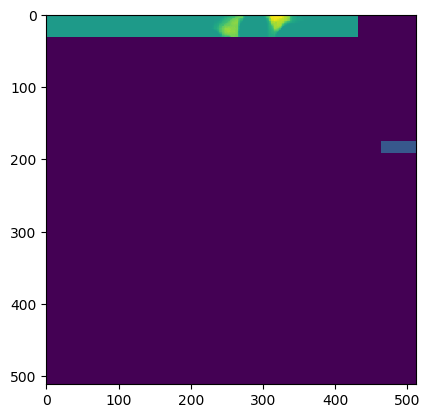

PyObject <matplotlib.image.AxesImage object at 0x0000000035DF5978>

In [18]:
imshow(mc_surface)

In [10]:
lines(sin.(1:.01:6))

In [438]:
world_surface = chunk.payload[1].payload[7].payload[4].payload

#Pallete
chunk.payload[1].payload[12].payload[2][2][1]

chunk.payload[1].payload[12].payload[2][2][2].payload[2]
0

0

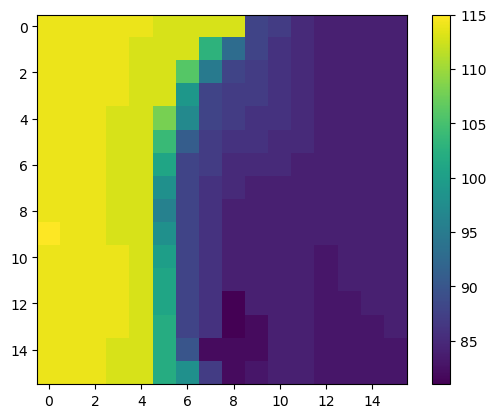

PyObject <matplotlib.colorbar.Colorbar object at 0x000000003C8A34A8>

In [399]:
imshow(get9(world_surface))
colorbar()

In [434]:
[i for i in 1:23]

23-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23

In [15]:
chunks[16, 16]

Tag("", Tag[Tag("Level", Tag[Tag("Status", "full"), Tag("zPos", 15), Tag("LastUpdate", 4113), Tag("Biomes", Int32[2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), Tag("InhabitedTime", 0), Tag("xPos", 15), Tag("Heightmaps", Tag[Tag("OCEAN_FLOOR", UInt64[0x1c8e472391c8e472, 0x8e472391c8e47239, 0x472391c8e472391c, 0x2391c8e472391c8e, 0x91c8e472391c8e47, 0xc8e472391c8e4723, 0xe472391c8e472391, 0x71389c4e271391c8, 0x389c4e472391c8e2, 0x9c4e271389c4e272  …  0x2a150a8542a150a8, 0x150a8542a150a854, 0xca6532994ca8542a, 0x8542a150a8542994, 0x32a150a8542a150a, 0xa150a8542994ca65, 0x50a8542a150a8542, 0xa8542994ca6542a1, 0x542a150a8542a150, 0x2994ca8542a150a8]), Tag("MOTION_BLOCKING_NO_LEAVES", UInt64[0x1c8e472391c8e472, 0x8e472391c8e47239, 0x472391c8e472391c, 0x2391c8e472391c8e, 0x91c8e472391c8e47, 0xc8e472391c8e4723, 0xe472391c8e472391, 0x71389c4e271391c8, 0x389c4e472391c8e2, 0x9c4e271389c4e272  …  0x2a150a8542a150a8, 0x150a8542a150a854, 0xca6532994ca8542a, 0x8542a150a8542994, 0x3